<a href="https://colab.research.google.com/github/ShabbyBoy5/project-1/blob/Causality/Causality_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mitbih_feature_pipeline.py

import numpy as np
import pandas as pd
from pathlib import Path
from scipy import signal, stats
from sklearn.preprocessing import StandardScaler
import wfdb

# ----------------- Config -----------------
FS = 360  # Hz (MIT-BIH sampling frequency)
# Keep only beat annotations; exclude non-beat marks like '+' etc.
# WFDB annotation symbols list: main beat types include 'N', 'L', 'R', 'V', 'A', etc.
# You can extend this map as needed.
AAMI_MAP = {
    # N class
    'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
    # SVEB (S)
    'A': 'S', 'a': 'S', 'J': 'S', 'S': 'S',
    # VEB (V)
    'V': 'V', 'E': 'V',
    # F (fusion of V and N)
    'F': 'F',
    # Q (unknown / paced etc.) - optional
    '/': 'Q', 'f': 'Q', 'Q': 'Q', 'P': 'Q'
}
VALID_BEAT_SYMBOLS = set(AAMI_MAP.keys())

# ----------------- IO helpers -----------------
def read_record_signal(record_name: str, data_dir: str | None = None, pn_dir: str | None = None):
    """
    Reads a MIT-BIH record from either a local directory (data_dir) or PhysioNet (pn_dir).
    Chooses MLII if present, otherwise uses the first channel.
    Returns signal (np.ndarray, shape [T,]), fields dict.
    """
    if data_dir:
        rec_path = str((Path(data_dir) / record_name).as_posix())
        rec = wfdb.rdrecord(rec_path)
    elif pn_dir:
        rec = wfdb.rdrecord(record_name, pn_dir=pn_dir)
    else:
        rec = wfdb.rdrecord(record_name)
    sig = rec.p_signal  # shape [T, n_sig]
    sig_names = [str(x) for x in rec.sig_name]
    # Prefer MLII else V5 else channel 0
    ch = 0
    if 'MLII' in sig_names:
        ch = sig_names.index('MLII')
    elif 'V5' in sig_names:
        ch = sig_names.index('V5')
    return sig[:, ch].astype(np.float32), {'fs': rec.fs, 'sig_name': sig_names}

def read_annotations(record_name: str, data_dir: str | None = None, pn_dir: str | None = None):
    """
    Reads ATR annotations for the record from local directory or PhysioNet.
    Returns sample indices and symbols.
    """
    if data_dir:
        rec_path = str((Path(data_dir) / record_name).as_posix())
        ann = wfdb.rdann(rec_path, 'atr')
    elif pn_dir:
        ann = wfdb.rdann(record_name, 'atr', pn_dir=pn_dir)
    else:
        ann = wfdb.rdann(record_name, 'atr')
    return ann.sample.astype(int), list(ann.symbol)

# ----------------- Filtering -----------------
def bandpass_filter(x, fs=FS, low=0.5, high=40.0, order=4):
    nyq = 0.5 * fs
    b, a = signal.butter(order, [low/nyq, high/nyq], btype='band')
    return signal.filtfilt(b, a, x)

def notch_filter(x, fs=FS, f0=60.0, Q=30.0):
    b, a = signal.iirnotch(f0, Q, fs)
    return signal.filtfilt(b, a, x)

# ----------------- Beat segmentation -----------------
def segment_beats(signal_1d, ann_samples, ann_symbols, fs=FS,
                  pre_ms=200, post_ms=400, keep_symbols=VALID_BEAT_SYMBOLS):
    """
    Extract fixed windows around annotated beats.
    pre_ms/post_ms define window relative to annotation sample (often near R-peak).
    Returns beats_X (N, W), beat_symbols (N,), beat_locs (N,)
    """
    pre = int(round(pre_ms * 1e-3 * fs))
    post = int(round(post_ms * 1e-3 * fs))
    W = pre + post
    beats = []
    labels = []
    locs = []
    T = len(signal_1d)
    for s, sym in zip(ann_samples, ann_symbols):
        if sym not in keep_symbols:
            continue
        start = s - pre
        end = s + post
        if start >= 0 and end <= T:
            seg = signal_1d[start:end].copy()
            beats.append(seg)
            labels.append(sym)
            locs.append(s)
    if len(beats) == 0:
        return np.zeros((0, W), dtype=np.float32), [], []
    return np.stack(beats).astype(np.float32), labels, locs

# ----------------- Feature extraction -----------------
def time_features(x):
    dx = np.diff(x)
    return {
        "mean": float(np.mean(x)),
        "std": float(np.std(x)),
        "min": float(np.min(x)),
        "max": float(np.max(x)),
        "skew": float(stats.skew(x)),
        "kurt": float(stats.kurtosis(x, fisher=True)),
        "rms": float(np.sqrt(np.mean(x**2))),
        "zcr": float(((x[:-1] * x[1:]) < 0).sum()),
        "slope": float(np.polyfit(np.arange(len(x)), x, 1)[0]),
        "energy": float(np.sum(x**2)),
        "abs_change": float(np.mean(np.abs(dx)))
    }

def welch_features(x, fs=FS):
    f, Pxx = signal.welch(x, fs=fs, nperseg=min(256, len(x)))
    Pxx = Pxx + 1e-12
    centroid = np.sum(f * Pxx) / np.sum(Pxx)
    bandwidth = np.sqrt(np.sum(((f - centroid) ** 2) * Pxx) / np.sum(Pxx))
    dom_freq = f[np.argmax(Pxx)]
    flatness = np.exp(np.mean(np.log(Pxx))) / np.mean(Pxx)
    return {
        "spec_centroid": float(centroid),
        "spec_bw": float(bandwidth),
        "spec_dom_freq": float(dom_freq),
        "spec_flatness": float(flatness),
        "psd_mean": float(Pxx.mean()),
        "psd_var": float(Pxx.var())
    }

def simple_morph_ecg(x, prominence=0.2):
    # Local peaks; note beats are already centered near R, but morphology helps
    peaks, props = signal.find_peaks(x, prominence=prominence)
    n_peaks = len(peaks)
    peak_amp_mean = float(np.mean(x[peaks])) if n_peaks > 0 else 0.0
    peak_prom_mean = float(np.mean(props.get("prominences", [0.0]))) if n_peaks > 0 else 0.0
    return {
        "n_peaks": float(n_peaks),
        "peak_amp_mean": peak_amp_mean,
        "peak_prom_mean": peak_prom_mean
    }

def acf_features(x, max_lag=10):
    x = (x - np.mean(x)) / (np.std(x) + 1e-8)
    acf = [1.0]
    for lag in range(1, max_lag+1):
        if len(x) > lag:
            ac = np.corrcoef(x[:-lag], x[lag:])[0,1]
        else:
            ac = 0.0
        acf.append(float(ac))
    return {f"acf_lag{lag}": acf[lag] for lag in range(1, max_lag+1)}

def extract_features_matrix(beats, fs=FS):
    rows = []
    for i in range(beats.shape[0]):
        x = beats[i]
        feats = {}
        feats.update(time_features(x))
        feats.update(welch_features(x, fs=fs))
        feats.update(simple_morph_ecg(x))
        feats.update(acf_features(x, max_lag=10))
        rows.append(feats)
    return pd.DataFrame(rows)

# ----------------- Orchestration -----------------
def process_record(record_name: str, data_dir: str | None = None, pn_dir: str | None = None,
                   use_notch=False, pre_ms=200, post_ms=400,
                   per_record_zscore=True):
    # Read signal and annotations
    sig, meta = read_record_signal(record_name, data_dir=data_dir, pn_dir=pn_dir)
    fs = int(meta['fs']) if 'fs' in meta else FS  # wfdb.rdrecord has fs
    ann_samp, ann_sym = read_annotations(record_name, data_dir=data_dir, pn_dir=pn_dir)

    # Filter
    x = bandpass_filter(sig, fs=fs, low=0.5, high=40.0, order=4)
    if use_notch:
        x = notch_filter(x, fs=fs, f0=60.0, Q=30.0)

    # Optional per-record standardization (helps stabilize features)
    if per_record_zscore:
        mu, sd = np.mean(x), np.std(x) + 1e-8
        x = (x - mu) / sd

    # Segment beats
    beats, beat_syms, beat_locs = segment_beats(
        x, ann_samp, ann_sym, fs=fs, pre_ms=pre_ms, post_ms=post_ms
    )

    # Map symbols to AAMI classes and to binary anomaly labels
    aami_labels = [AAMI_MAP.get(s, 'Q') for s in beat_syms]
    # Example binary: normal (N) vs anomaly (non-N)
    y_binary = np.array([1 if lab == 'N' else 0 for lab in aami_labels], dtype=int)

    # Features
    feat_df = extract_features_matrix(beats, fs=fs)
    feat_df['symbol'] = beat_syms
    feat_df['aami'] = aami_labels
    feat_df['y_binary_normal_is_1'] = y_binary
    feat_df['record'] = record_name
    feat_df['r_sample'] = beat_locs
    return beats, feat_df

def run_mitbih_pipeline(record_list, out_dir="artifacts/mitbih",
                        data_dir: str | None = None, pn_dir: str | None = None, use_notch=False,
                        pre_ms=200, post_ms=400):
    out = Path(out_dir)
    out.mkdir(parents=True, exist_ok=True)
    all_feats = []
    beats_by_rec = {}
    for rec in record_list:
        beats, feat = process_record(
            rec, data_dir=data_dir, pn_dir=pn_dir, use_notch=use_notch,
            pre_ms=pre_ms, post_ms=post_ms
        )
        beats_by_rec[rec] = beats
        all_feats.append(feat)
        # Save per-record arrays
        np.save(out / f"{rec}_beats.npy", beats)
        feat.to_csv(out / f"{rec}_features.csv", index=False)
    feat_all = pd.concat(all_feats, axis=0, ignore_index=True) if all_feats else pd.DataFrame()
    feat_all.to_csv(out / "all_records_features.csv", index=False)
    return beats_by_rec, feat_all

if __name__ == "__main__":
    # Example usage with local dataset stored under data/mit-bih-arrhythmia-database-1.0.0
    # Choose a subset of records, e.g., '100','101','103','105'
    records = ['100', '101', '103', '105']
    beats_by_record, features_all = run_mitbih_pipeline(
        records,
        out_dir="artifacts/mitbih",
        data_dir="/content/drive/MyDrive/data/mit-bih-arrhythmia-database-1.0.0",
        pn_dir=None,  # Or set to 'mitdb' to fetch from PhysioNet if not local
        use_notch=False,
    )


In [ ]:
# mitbih_wavelet_delineation_features.py
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple
import wfdb
from scipy import signal
import pywt

FS = 360  # MIT-BIH sampling rate

# ------------------- RR / HR / HRV -------------------
def load_annotations(record: str, pb_dir='mitdb/'):
    ann = wfdb.rdann(record, 'atr', pn_dir=pb_dir if pb_dir else None)
    return ann.sample.astype(int), list(ann.symbol)

def compute_rr_series(ann_samples: np.ndarray) -> np.ndarray:
    return np.diff(ann_samples).astype(float)

def instantaneous_hr_from_rr(rr_samples: float, fs=FS) -> float:
    rr_sec = rr_samples / fs
    return 60.0 / rr_sec if rr_sec > 0 else np.nan

def hrv_time_metrics(rr_series_samples: np.ndarray, fs=FS) -> Dict[str, float]:
    if rr_series_samples.size < 2:
        return {"SDNN": np.nan, "RMSSD": np.nan}
    rr_ms = (rr_series_samples / fs) * 1000.0
    sdnn = float(np.std(rr_ms, ddof=1)) if rr_ms.size >= 2 else np.nan
    diff = np.diff(rr_ms)
    rmssd = float(np.sqrt(np.mean(diff**2))) if diff.size >= 1 else np.nan
    return {"SDNN": sdnn, "RMSSD": rmssd}

# ------------------- Wavelet delineation -------------------
# Approach:
# 1) Band-limit beat for stability (optional if upstream filtered) [0.5,40] Hz.
# 2) CWT with a mother wavelet suitable for QRS (e.g., Mexican hat) across scales spanning ~10–60 ms.
# 3) Use modulus maxima and zero-crossings to estimate QRS onset/offset around the R center; search earlier for P, later for T.
# References: wavelet delineation literature and validated algorithms on PhysioNet [web:106][web:86].

def bandpass(x, fs=FS, low=0.5, high=40.0, order=4):
    nyq = 0.5 * fs
    b, a = signal.butter(order, [low/nyq, high/nyq], btype='band')
    return signal.filtfilt(b, a, x)

def wavelet_delineate_beat(beat: np.ndarray, fs=FS, pre_ms=200, post_ms=400) -> Dict[str, float]:
    W = len(beat)
    # Ensure filtered
    xb = bandpass(beat, fs=fs, low=0.5, high=40.0, order=4)
    # Choose mother wavelet: Mexican hat ('mexh') is commonly used for QRS [web:106].
    # Build scales to capture 10–60 ms widths: scale ~ width / dt; dt=1/fs.
    dt = 1.0 / fs
    widths = np.arange(int(0.01/dt), int(0.06/dt))  # samples: 10–60 ms
    # Use CWT via convolution approximation: pywt.cwt expects scales, returns coefficients per scale.
    # Translate widths to scales; for 'mexh', scale is proportional to width; use widths directly as scales proxy.
    cwt_coeffs, freqs = pywt.cwt(xb, scales=widths, wavelet='mexh', sampling_period=dt)
    # Aggregate across scales (energy)
    cwt_energy = np.mean(np.abs(cwt_coeffs), axis=0)
    # R index assumed at center of window
    pre = int(round(pre_ms * 1e-3 * fs))
    R_idx = pre
    # QRS boundaries: search around R for strong energy transitions
    left = max(0, R_idx - int(0.12*fs))
    right = min(W-1, R_idx + int(0.12*fs))
    seg = cwt_energy[left:right+1]
    # Threshold relative to segment stats
    thr = np.percentile(seg, 60)
    # QRS onset: last index before R where energy rises above thr
    qrs_on = None
    for i in range(R_idx - left, -1, -1):
        if seg[i] > thr:
            qrs_on = left + i
    if qrs_on is None:
        qrs_on = max(0, R_idx - int(0.04*fs))
    # QRS offset: first index after R where energy drops below thr
    qrs_off = None
    for i in range(R_idx - left, len(seg)):
        if seg[i] < thr:
            qrs_off = left + i
            break
    if qrs_off is None:
        qrs_off = min(W-1, R_idx + int(0.06*fs))
    qrs_on = max(0, min(W-1, qrs_on))
    qrs_off = max(0, min(W-1, qrs_off))
    qrs_dur = (qrs_off - qrs_on) / fs

    # P wave: search before QRS onset using lower scales (broader waves) for P detection
    p_left = max(0, qrs_on - int(0.24*fs))
    p_right = max(0, qrs_on - int(0.04*fs))
    if p_right > p_left:
        # Favor slightly larger scales to capture P morphology; use median across top scales.
        top_scales = cwt_coeffs[-10:, p_left:p_right]
        p_energy = np.mean(np.abs(top_scales), axis=0)
        P_rel = int(np.argmax(p_energy))
        P_idx = p_left + P_rel
        P_amp = float(xb[P_idx])
    else:
        P_idx = max(0, qrs_on - int(0.12*fs))
        P_amp = float(xb[P_idx])

    # T wave: search after QRS offset
    t_left = min(W-1, qrs_off + int(0.04*fs))
    t_right = min(W-1, qrs_off + int(0.4*fs))
    if t_right > t_left:
        top_scales = cwt_coeffs[-10:, t_left:t_right]
        t_energy = np.mean(np.abs(top_scales), axis=0)
        T_rel = int(np.argmax(t_energy))
        T_idx = t_left + T_rel
        T_amp = float(xb[T_idx])
    else:
        T_idx = min(W-1, qrs_off + int(0.2*fs))
        T_amp = float(xb[T_idx])

    # Intervals
    PR = (qrs_on - P_idx) / fs if qrs_on >= P_idx else np.nan
    QT = (T_idx - qrs_on) / fs if T_idx >= qrs_on else np.nan
    # J-point ~ QRS offset; ST deviation = value at J minus baseline (pre-P median)
    base_start = max(0, P_idx - int(0.08*fs))
    base_end = max(1, P_idx - int(0.02*fs))
    baseline = float(np.median(xb[base_start:base_end])) if base_end > base_start else float(np.median(xb[:max(1,int(0.04*fs))]))
    ST_dev = float(xb[qrs_off] - baseline)
    R_amp = float(xb[R_idx])

    return {
        "PR_s": PR,
        "QRS_s": qrs_dur,
        "QT_s": QT,
        "ST_dev": ST_dev,
        "R_amp": R_amp,
        "T_amp": T_amp,
        "P_idx": P_idx,
        "QRS_on": qrs_on,
        "QRS_off": qrs_off,
        "T_idx": T_idx
    }

def qtc_bazett(qt_sec: float, rr_samples: float, fs=FS) -> float:
    if qt_sec is None or np.isnan(qt_sec) or rr_samples is None or np.isnan(rr_samples) or rr_samples <= 0:
        return np.nan
    rr_sec = rr_samples / fs
    return float(qt_sec / np.sqrt(rr_sec))

# ------------------- Augmentation driver -------------------
def augment_with_wavelet_clinical(
    features_csv: str,
    pb_dir='mitdb/',
    pre_ms=200,
    post_ms=400,
    hrv_window_beats=30
) -> pd.DataFrame:
    df = pd.read_csv(features_csv)
    df['record'] = df['record'].astype(str)

    PR_list, QRS_list, QT_list, QTc_list, ST_list, R_amp_list, T_amp_list = [], [], [], [], [], [], []
    RR_list, HR_list, SDNN_list, RMSSD_list = [], [], [], []

    for rec, g in df.groupby('record'):
        ann_samples, ann_symbols = load_annotations(rec, pb_dir=pb_dir)
        idx_map = {int(s): i for i, s in enumerate(ann_samples)}
        # Load raw signal once for delineation
        recsig = wfdb.rdrecord(rec, pn_dir=pb_dir if pb_dir else None)
        # Prefer MLII or first channel
        ch = 0
        if 'MLII' in recsig.sig_name:
            ch = recsig.sig_name.index('MLII')
        elif 'V5' in recsig.sig_name:
            ch = recsig.sig_name.index('V5')
        sig = recsig.p_signal[:, ch].astype(np.float32)

        for _, row in g.iterrows():
            r_samp = int(row['r_sample'])
            # RR/HRV
            if r_samp in idx_map and idx_map[r_samp] > 0:
                i = idx_map[r_samp]
                rr_curr = float(ann_samples[i] - ann_samples[i-1])
                RR_list.append(rr_curr)
                HR_list.append(instantaneous_hr_from_rr(rr_curr, fs=FS))
                start_i = max(1, i - hrv_window_beats)
                rr_win = np.diff(ann_samples[start_i:i+1])
                hrv = hrv_time_metrics(rr_win, fs=FS)
                SDNN_list.append(hrv["SDNN"])
                RMSSD_list.append(hrv["RMSSD"])
            else:
                RR_list.append(np.nan); HR_list.append(np.nan); SDNN_list.append(np.nan); RMSSD_list.append(np.nan)

            # Build beat window around r_samp
            pre = int(round(pre_ms * 1e-3 * FS))
            post = int(round(post_ms * 1e-3 * FS))
            start = r_samp - pre
            end = r_samp + post
            if start >= 0 and end <= len(sig):
                beat = sig[start:end].copy()
                d = wavelet_delineate_beat(beat, fs=FS, pre_ms=pre_ms, post_ms=post_ms)
                PR_list.append(d["PR_s"])
                QRS_list.append(d["QRS_s"])
                QT_list.append(d["QT_s"])
                ST_list.append(d["ST_dev"])
                R_amp_list.append(d["R_amp"])
                T_amp_list.append(d["T_amp"])
                QTc_list.append(qtc_bazett(d["QT_s"], RR_list[-1], fs=FS))
            else:
                PR_list.append(np.nan); QRS_list.append(np.nan); QT_list.append(np.nan); ST_list.append(np.nan)
                R_amp_list.append(np.nan); T_amp_list.append(np.nan); QTc_list.append(np.nan)

    df['RR_samples'] = RR_list
    df['HR_bpm'] = HR_list
    df['SDNN_ms'] = SDNN_list
    df['RMSSD_ms'] = RMSSD_list
    df['PR_s'] = PR_list
    df['QRS_s'] = QRS_list
    df['QT_s'] = QT_list
    df['QTc_Bazett_s'] = QTc_list
    df['ST_dev'] = ST_list
    df['R_amp'] = R_amp_list
    df['T_amp'] = T_amp_list
    return df

if __name__ == "__main__":
    # Input from your existing pipeline
    in_csv = "/content/artifacts/mitbih/all_records_features.csv"
    out_csv = "artifacts/mitbih/all_records_features_wavelet_clinical.csv"
    df_aug = augment_with_wavelet_clinical(in_csv, pb_dir='mitdb/')
    Path(out_csv).parent.mkdir(parents=True, exist_ok=True)
    df_aug.to_csv(out_csv, index=False)
    print("Saved:", out_csv)


Saved: artifacts/mitbih/all_records_features_wavelet_clinical.csv


In [ ]:
!pip install tigramite

In [ ]:
!pip uninstall tigramite -y
!pip install tigramite --force-reinstall

Found existing installation: tigramite 5.2.9.4
Uninstalling tigramite-5.2.9.4:
  Successfully uninstalled tigramite-5.2.9.4
  Using cached tigramite-5.2.9.4-py3-none-any.whl.metadata (11 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.8 MB/s eta 0:00:00
Using cached tigramite-5.2.9.4-py3-none-any.whl (313 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 21.5 MB/s eta 0:00:00
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Successfully uninstalled six-1.17.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy

In [ ]:
!pip install statsmodels

In [ ]:
import pandas as pd

# Load the CSV
df = pd.read_csv('artifacts/mitbih/all_records_features_wavelet_clinical.csv')

# Check available records
print("Available records in CSV:")
print(df['record'].unique())

# Count beats per record
print("\nBeats per record:")
record_counts = df.groupby('record').size().sort_values(ascending=False)
print(record_counts)

# Check for NaNs in selected features
selected_features = [
    'HR_bpm', 'SDNN_ms', 'RMSSD_ms', 'PR_s', 'QRS_s', 'QTc_Bazett_s',
    'ST_dev', 'R_amp', 'T_amp', 'spec_centroid', 'rms'
]

print("\nChecking data availability for each record:")
for record in df['record'].unique():
    df_rec = df[df['record'] == record]
    df_clean = df_rec[selected_features].dropna()
    print(f"Record {record}: {len(df_rec)} total beats, {len(df_clean)} clean beats")


Available records in CSV:
[100 101 103 105]

Beats per record:
record
105    2572
100    2272
103    2083
101    1865
dtype: int64

Checking data availability for each record:
Record 100: 2272 total beats, 2270 clean beats
Record 101: 1865 total beats, 1863 clean beats
Record 103: 2083 total beats, 2081 clean beats
Record 105: 2572 total beats, 2570 clean beats


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings('ignore')

# Load your CSV (in Colab, make sure file is uploaded first)
df = pd.read_csv('/content/artifacts/mitbih/all_records_features.csv')

# Select features that exist in your CSV
selected_features = [
    'mean', 'std', 'rms', 'skew', 'kurt', 'energy',
    'spec_centroid', 'spec_bw', 'n_peaks', 'peak_amp_mean'
]

print("="*60)
print("GRANGER CAUSALITY ANALYSIS - MIT-BIH ECG FEATURES")
print("="*60)
print(f"\nRecords available: {df['record'].unique()}")
print(f"Total beats in dataset: {len(df)}")

# Use record 105 (has most data)
selected_record = 105
print(f"\n🎯 Analyzing Record {selected_record}")

df_record = df[df['record'] == selected_record].sort_values('r_sample')
df_clean = df_record[selected_features].dropna().reset_index(drop=True)

print(f"✓ Clean beats for analysis: {len(df_clean)}")
print(f"✓ Features: {', '.join(selected_features)}\n")

# Set maximum lag
max_lag = 3
print(f"Testing with max lag = {max_lag} beats\n")

# Store results
results_dict = {}
tested = 0
significant = 0

# Test all pairwise Granger causality
print("Testing Granger causality relationships...")
print("-" * 60)

for cause_var in selected_features:
    for effect_var in selected_features:
        if cause_var == effect_var:
            continue

        data = df_clean[[effect_var, cause_var]].values

        if len(data) < 2 * max_lag + 10:
            continue

        try:
            test_result = grangercausalitytests(data, max_lag, verbose=False)
            tested += 1

            p_values = []
            for lag in range(1, max_lag + 1):
                p_val = test_result[lag][0]['ssr_ftest'][1]
                p_values.append(p_val)

            min_p = min(p_values)
            best_lag = p_values.index(min_p) + 1

            if min_p < 0.05:
                significant += 1
                results_dict[f"{cause_var} -> {effect_var}"] = {
                    'p_value': min_p,
                    'best_lag': best_lag
                }
                print(f"✓ {cause_var:15} → {effect_var:15}  lag={best_lag}, p={min_p:.5f}")

        except Exception as e:
            pass

print("-" * 60)
print(f"Tested: {tested} relationships | Significant: {significant}\n")

# Summary
print("="*60)
print("SUMMARY: SIGNIFICANT CAUSAL RELATIONSHIPS (p < 0.05)")
print("="*60)

if results_dict:
    sorted_results = sorted(results_dict.items(), key=lambda x: x[1]['p_value'])
    for i, (relationship, info) in enumerate(sorted_results, 1):
        print(f"{i:2d}. {relationship:30} p={info['p_value']:.5f}, lag={info['best_lag']}")

    # Save to CSV
    results_df = pd.DataFrame(results_dict).T
    results_df.to_csv(f'granger_results_record_{selected_record}.csv')
    print(f"\n✅ Results saved to: granger_results_record_{selected_record}.csv")
else:
    print("No significant Granger causal relationships found at p<0.05")

print("\n" + "="*60)


GRANGER CAUSALITY ANALYSIS - MIT-BIH ECG FEATURES

Records available: [100 101 103 105]
Total beats in dataset: 8792

🎯 Analyzing Record 105
✓ Clean beats for analysis: 2572
✓ Features: mean, std, rms, skew, kurt, energy, spec_centroid, spec_bw, n_peaks, peak_amp_mean

Testing with max lag = 3 beats

Testing Granger causality relationships...
------------------------------------------------------------
✓ mean            → std              lag=1, p=0.00000
✓ mean            → rms              lag=1, p=0.00000
✓ mean            → skew             lag=3, p=0.04106
✓ mean            → energy           lag=1, p=0.00000
✓ mean            → spec_centroid    lag=3, p=0.00558
✓ mean            → n_peaks          lag=1, p=0.00120
✓ mean            → peak_amp_mean    lag=2, p=0.00000
✓ std             → mean             lag=3, p=0.00219
✓ std             → rms              lag=3, p=0.00000
✓ std             → skew             lag=1, p=0.00000
✓ std             → kurt             lag=2, p=0.00000


In [ ]:
!pip install networkx

In [ ]:
!pip install matplotlib

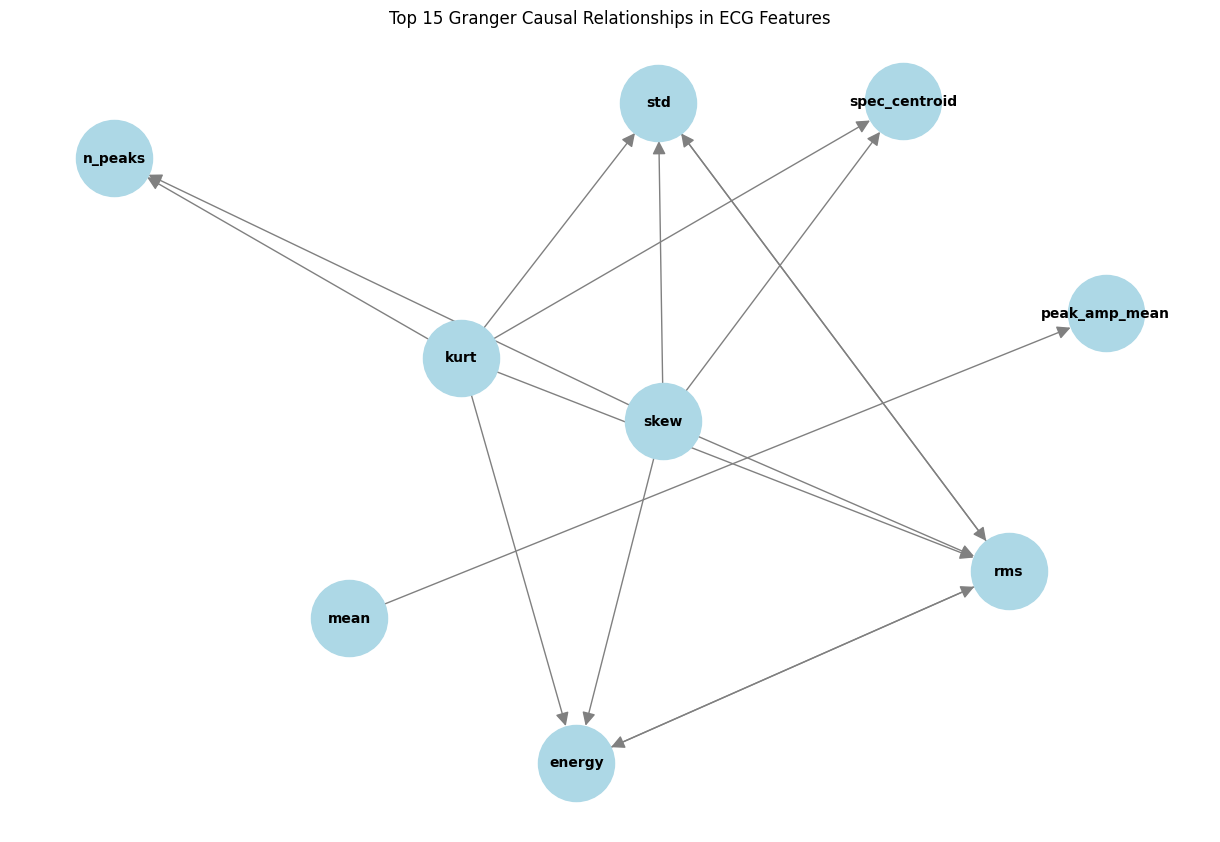

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create directed graph
G = nx.DiGraph()

# Add top 15 strongest edges
top_15 = [
    ('mean', 'peak_amp_mean'), ('rms', 'energy'), ('skew', 'energy'),
    ('skew', 'std'), ('kurt', 'spec_centroid'), ('skew', 'rms'),
    ('kurt', 'std'), ('kurt', 'energy'), ('rms', 'std'),
    ('energy', 'rms'), ('skew', 'n_peaks'), ('kurt', 'rms'),
    ('kurt', 'n_peaks'), ('skew', 'spec_centroid'), ('std', 'rms')
]

G.add_edges_from(top_15)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=2, iterations=50)
nx.draw(G, pos, with_labels=True, node_color='lightblue',
        node_size=3000, font_size=10, font_weight='bold',
        arrows=True, arrowsize=20, edge_color='gray')
plt.title('Top 15 Granger Causal Relationships in ECG Features')
plt.tight_layout()
plt.savefig('granger_causal_graph.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import wfdb
from scipy.signal import find_peaks
import pywt
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set data path
DATA_PATH = '/content/drive/MyDrive/data/mit-bih-arrhythmia-database-1.0.0'

def delineate_beat_wavelet(beat_signal, r_idx_in_beat, fs=360):
    """Wavelet-based ECG delineation to find P, Q, R, S, T wave boundaries"""
    widths = np.arange(1, 31)
    cwt_matrix, _ = pywt.cwt(beat_signal, widths, 'mexh')

    r_idx = r_idx_in_beat

    # Find Q (local minimum before R)
    q_search_start = max(0, r_idx - int(0.08 * fs))
    q_search_end = r_idx
    q_search = beat_signal[q_search_start:q_search_end]
    if len(q_search) > 5:
        q_idx = q_search_start + np.argmin(q_search)
    else:
        q_idx = None

    # Find S (local minimum after R)
    s_search_start = r_idx
    s_search_end = min(len(beat_signal), r_idx + int(0.08 * fs))
    s_search = beat_signal[s_search_start:s_search_end]
    if len(s_search) > 5:
        s_idx = s_search_start + np.argmin(s_search)
    else:
        s_idx = None

    # Find T (next significant peak after S)
    t_search_start = r_idx + int(0.08 * fs)
    t_search_end = min(len(beat_signal), r_idx + int(0.4 * fs))
    t_search = beat_signal[t_search_start:t_search_end]
    if len(t_search) > 20:
        t_peaks, properties = find_peaks(t_search, prominence=np.std(beat_signal)*0.5)
        if len(t_peaks) > 0:
            t_idx = t_search_start + t_peaks[0]
        else:
            t_idx = t_search_start + np.argmax(np.abs(t_search))
    else:
        t_idx = None

    # Find P (peak before Q)
    p_search_start = max(0, r_idx - int(0.25 * fs))
    p_search_end = max(0, r_idx - int(0.08 * fs))
    p_search = beat_signal[p_search_start:p_search_end]
    if len(p_search) > 20:
        p_peaks, _ = find_peaks(p_search, prominence=np.std(beat_signal)*0.3)
        if len(p_peaks) > 0:
            p_idx = p_search_start + p_peaks[-1]
        else:
            p_idx = None
    else:
        p_idx = None

    # Calculate ST segment deviation
    if s_idx:
        st_point_idx = min(len(beat_signal)-1, s_idx + int(0.06 * fs))
        st_dev = beat_signal[st_point_idx] - beat_signal[s_idx]
    else:
        st_dev = None

    return {
        'P': p_idx, 'Q': q_idx, 'R': r_idx,
        'S': s_idx, 'T': t_idx, 'ST_dev': st_dev
    }

def calculate_hrv(rr_intervals):
    """Calculate heart rate variability metrics"""
    if len(rr_intervals) < 2:
        return {'SDNN_ms': np.nan, 'RMSSD_ms': np.nan}

    rr_ms = rr_intervals * 1000
    sdnn = np.std(rr_ms)
    diff_rr = np.diff(rr_ms)
    rmssd = np.sqrt(np.mean(diff_rr**2))

    return {'SDNN_ms': sdnn, 'RMSSD_ms': rmssd}

# Main extraction
print("="*60)
print("EXTRACTING CLINICAL ECG FEATURES (P, Q, R, S, T)")
print("="*60)

records = ['100', '101', '103', '105']
all_features = []

for record in records:
    print(f"\nProcessing record {record}...")

    try:
        # Load ECG signal
        signals, fields = wfdb.rdsamp(f'{DATA_PATH}/{record}')
        ecg = signals[:, 0]
        fs = fields['fs']

        # Load R-peak annotations
        ann = wfdb.rdann(f'{DATA_PATH}/{record}', 'atr')
        r_peaks = ann.sample
        symbols = ann.symbol

        # Calculate RR intervals
        rr_intervals = np.diff(r_peaks) / fs

        for i in range(1, len(r_peaks) - 1):
            r_peak = r_peaks[i]

            # Extract beat window
            beat_start = max(0, r_peak - int(0.2 * fs))
            beat_end = min(len(ecg), r_peak + int(0.4 * fs))
            beat = ecg[beat_start:beat_end]

            if len(beat) < 100:
                continue

            # R peak location within beat window
            r_idx_in_beat = r_peak - beat_start

            # Delineate the beat
            points = delineate_beat_wavelet(beat, r_idx_in_beat, fs)

            # Calculate intervals
            pr_s = (points['R'] - points['P']) / fs if points['P'] and points['R'] else np.nan
            qrs_s = (points['S'] - points['Q']) / fs if points['Q'] and points['S'] else np.nan
            qt_s = (points['T'] - points['Q']) / fs if points['Q'] and points['T'] else np.nan

            # Calculate QTc using Bazett's formula
            rr_current = rr_intervals[i-1]
            qtc_bazett = qt_s / np.sqrt(rr_current) if not np.isnan(qt_s) else np.nan

            # Calculate heart rate
            hr_bpm = 60.0 / rr_current

            # Calculate HRV metrics
            hrv_window = rr_intervals[max(0, i-10):i+1]
            hrv_metrics = calculate_hrv(hrv_window)

            # Extract amplitudes
            r_amp = beat[points['R']] if points['R'] else np.nan
            t_amp = beat[points['T']] if points['T'] else np.nan
            p_amp = beat[points['P']] if points['P'] else np.nan
            q_amp = beat[points['Q']] if points['Q'] else np.nan
            s_amp = beat[points['S']] if points['S'] else np.nan

            # Store features
            features = {
                'record': record,
                'r_sample': r_peak,
                'symbol': symbols[i],
                'HR_bpm': hr_bpm,
                'SDNN_ms': hrv_metrics['SDNN_ms'],
                'RMSSD_ms': hrv_metrics['RMSSD_ms'],
                'PR_s': pr_s,
                'QRS_s': qrs_s,
                'QT_s': qt_s,
                'QTc_Bazett_s': qtc_bazett,
                'ST_dev': points['ST_dev'],
                'P_amp': p_amp,
                'Q_amp': q_amp,
                'R_amp': r_amp,
                'S_amp': s_amp,
                'T_amp': t_amp,
            }

            all_features.append(features)

        print(f"  ✓ Extracted {len([f for f in all_features if f['record'] == record])} beats")

    except Exception as e:
        print(f"  ✗ Error processing record {record}: {str(e)}")

# Save to CSV
df_clinical = pd.DataFrame(all_features)
df_clinical.to_csv('clinical_ecg_features.csv', index=False)

print(f"\n{'='*60}")
print(f"✅ SAVED {len(df_clinical)} beats to clinical_ecg_features.csv")
print(f"{'='*60}")
print(f"\nFeatures extracted:")
print(df_clinical.columns.tolist())
print(f"\nSample data:")
print(df_clinical.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
EXTRACTING CLINICAL ECG FEATURES (P, Q, R, S, T)

Processing record 100...
  ✓ Extracted 2272 beats

Processing record 101...
  ✓ Extracted 1872 beats

Processing record 103...
  ✓ Extracted 2089 beats

Processing record 105...
  ✓ Extracted 2689 beats

✅ SAVED 8922 beats to clinical_ecg_features.csv

Features extracted:
['record', 'r_sample', 'symbol', 'HR_bpm', 'SDNN_ms', 'RMSSD_ms', 'PR_s', 'QRS_s', 'QT_s', 'QTc_Bazett_s', 'ST_dev', 'P_amp', 'Q_amp', 'R_amp', 'S_amp', 'T_amp']

Sample data:
  record  r_sample symbol      HR_bpm     SDNN_ms    RMSSD_ms      PR_s  \
0    100        77      N  366.101695  325.000000  650.000000  0.144444   
1    100       370      N   73.720137  305.760313  459.623605  0.172222   
2    100       662      N   73.972603  277.618010  375.500352  0.163889   
3    100       946      N   76.056338  255.196608  325.195810  0.133333 

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings('ignore')

# Load clinical features
df = pd.read_csv('clinical_ecg_features.csv')

# Select clinical features
clinical_features = [
    'HR_bpm', 'SDNN_ms', 'RMSSD_ms',
    'PR_s', 'QRS_s', 'QT_s', 'QTc_Bazett_s',
    'ST_dev', 'R_amp', 'T_amp'
]

print("="*60)
print("GRANGER CAUSALITY ANALYSIS - CLINICAL ECG FEATURES")
print("="*60)
print(f"\nRecords available: {df['record'].unique()}")
print(f"Total beats in dataset: {len(df)}")

# Find records with sufficient data
valid_records = []
for record in df['record'].unique():
    df_rec = df[df['record'] == record]
    df_clean = df_rec[clinical_features].dropna()
    if len(df_clean) >= 50:
        valid_records.append((record, len(df_clean)))
        print(f"  ✓ Record {record}: {len(df_clean)} clean beats")

if not valid_records:
    print("\n❌ No records have sufficient data!")
    exit()

# Use record with most data
best_record = max(valid_records, key=lambda x: x[1])[0]
print(f"\n🎯 Analyzing Record {best_record}")

df_record = df[df['record'] == best_record].sort_values('r_sample')
df_clean = df_record[clinical_features].dropna().reset_index(drop=True)

print(f"✓ Clean beats for analysis: {len(df_clean)}")
print(f"✓ Features: {', '.join(clinical_features)}\n")

# Set maximum lag
max_lag = 3
print(f"Testing with max lag = {max_lag} beats\n")

# Store results
results_dict = {}
tested = 0
significant = 0

# Test all pairwise Granger causality
print("Testing Granger causality relationships...")
print("-" * 60)

for cause_var in clinical_features:
    for effect_var in clinical_features:
        if cause_var == effect_var:
            continue

        data = df_clean[[effect_var, cause_var]].values

        if len(data) < 2 * max_lag + 10:
            continue

        try:
            test_result = grangercausalitytests(data, max_lag, verbose=False)
            tested += 1

            p_values = []
            for lag in range(1, max_lag + 1):
                p_val = test_result[lag][0]['ssr_ftest'][1]
                p_values.append(p_val)

            min_p = min(p_values)
            best_lag = p_values.index(min_p) + 1

            if min_p < 0.05:
                significant += 1
                results_dict[f"{cause_var} -> {effect_var}"] = {
                    'p_value': min_p,
                    'best_lag': best_lag
                }
                print(f"✓ {cause_var:15} → {effect_var:15}  lag={best_lag}, p={min_p:.5f}")

        except Exception as e:
            pass

print("-" * 60)
print(f"Tested: {tested} relationships | Significant: {significant}\n")

# Summary
print("="*60)
print("SUMMARY: SIGNIFICANT CAUSAL RELATIONSHIPS (p < 0.05)")
print("="*60)

if results_dict:
    sorted_results = sorted(results_dict.items(), key=lambda x: x[1]['p_value'])
    for i, (relationship, info) in enumerate(sorted_results, 1):
        print(f"{i:2d}. {relationship:40} p={info['p_value']:.5f}, lag={info['best_lag']}")

    # Save to CSV
    results_df = pd.DataFrame(results_dict).T
    results_df.to_csv(f'granger_causality_clinical_record_{best_record}.csv')
    print(f"\n✅ Results saved to: granger_causality_clinical_record_{best_record}.csv")
else:
    print("No significant Granger causal relationships found at p<0.05")

print("\n" + "="*60)


GRANGER CAUSALITY ANALYSIS - CLINICAL ECG FEATURES

Records available: [100 101 103 105]
Total beats in dataset: 8922
  ✓ Record 100: 1472 clean beats
  ✓ Record 101: 1856 clean beats
  ✓ Record 103: 276 clean beats
  ✓ Record 105: 2462 clean beats

🎯 Analyzing Record 105
✓ Clean beats for analysis: 2462
✓ Features: HR_bpm, SDNN_ms, RMSSD_ms, PR_s, QRS_s, QT_s, QTc_Bazett_s, ST_dev, R_amp, T_amp

Testing with max lag = 3 beats

Testing Granger causality relationships...
------------------------------------------------------------
✓ HR_bpm          → SDNN_ms          lag=3, p=0.00000
✓ HR_bpm          → RMSSD_ms         lag=1, p=0.00000
✓ HR_bpm          → PR_s             lag=3, p=0.00000
✓ HR_bpm          → QT_s             lag=1, p=0.00031
✓ HR_bpm          → QTc_Bazett_s     lag=1, p=0.01197
✓ HR_bpm          → ST_dev           lag=1, p=0.00148
✓ HR_bpm          → R_amp            lag=3, p=0.00005
✓ HR_bpm          → T_amp            lag=1, p=0.00000
✓ SDNN_ms         → HR_bpm      

In [ ]:
import pandas as pd

# Load both feature sets
df_statistical = pd.read_csv('/content/artifacts/mitbih/all_records_features.csv')
df_clinical = pd.read_csv('/content/clinical_ecg_features.csv')

print("Statistical features shape:", df_statistical.shape)
print("Clinical features shape:", df_clinical.shape)

# Merge on record and r_sample
df_combined = pd.merge(
    df_statistical,
    df_clinical,
    on=['record', 'r_sample'],
    how='inner',
    suffixes=('_stat', '_clin')
)

print(f"\n✅ Combined {len(df_combined)} beats with both statistical and clinical features")
print(f"Total features: {len(df_combined.columns)}")
print(f"\nColumns: {df_combined.columns.tolist()}")

# Save combined dataset
df_combined.to_csv('combined_ecg_features.csv', index=False)
print(f"\n✅ Saved to: combined_ecg_features.csv")


Statistical features shape: (8792, 35)
Clinical features shape: (8922, 16)

✅ Combined 8790 beats with both statistical and clinical features
Total features: 49

Columns: ['mean', 'std', 'min', 'max', 'skew', 'kurt', 'rms', 'zcr', 'slope', 'energy', 'abs_change', 'spec_centroid', 'spec_bw', 'spec_dom_freq', 'spec_flatness', 'psd_mean', 'psd_var', 'n_peaks', 'peak_amp_mean', 'peak_prom_mean', 'acf_lag1', 'acf_lag2', 'acf_lag3', 'acf_lag4', 'acf_lag5', 'acf_lag6', 'acf_lag7', 'acf_lag8', 'acf_lag9', 'acf_lag10', 'symbol_stat', 'aami', 'y_binary_normal_is_1', 'record', 'r_sample', 'symbol_clin', 'HR_bpm', 'SDNN_ms', 'RMSSD_ms', 'PR_s', 'QRS_s', 'QT_s', 'QTc_Bazett_s', 'ST_dev', 'P_amp', 'Q_amp', 'R_amp', 'S_amp', 'T_amp']

✅ Saved to: combined_ecg_features.csv


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings('ignore')

# Load combined features
df = pd.read_csv('combined_ecg_features.csv')

# Select all important features (statistical + clinical)
selected_features = [
    # Statistical
    'mean', 'std', 'rms', 'energy', 'spec_centroid',
    # Clinical
    'HR_bpm', 'PR_s', 'QRS_s', 'QT_s', 'QTc_Bazett_s',
    'R_amp', 'T_amp', 'ST_dev'
]

print("="*60)
print("GRANGER CAUSALITY - COMBINED FEATURES")
print("="*60)

# Find best record
valid_records = []
for record in df['record'].unique():
    df_rec = df[df['record'] == record]
    df_clean = df_rec[selected_features].dropna()
    if len(df_clean) >= 50:
        valid_records.append((record, len(df_clean)))

best_record = max(valid_records, key=lambda x: x[1])[0]
df_record = df[df['record'] == best_record].sort_values('r_sample')
df_clean = df_record[selected_features].dropna().reset_index(drop=True)

print(f"Record: {best_record} | Beats: {len(df_clean)}\n")

# Run Granger causality
max_lag = 3
results_dict = {}
tested = 0
significant = 0

print("Testing Granger causality...")
print("-" * 60)

for cause_var in selected_features:
    for effect_var in selected_features:
        if cause_var == effect_var:
            continue

        data = df_clean[[effect_var, cause_var]].values

        if len(data) < 2 * max_lag + 10:
            continue

        try:
            test_result = grangercausalitytests(data, max_lag, verbose=False)
            tested += 1

            p_values = []
            for lag in range(1, max_lag + 1):
                p_val = test_result[lag][0]['ssr_ftest'][1]
                p_values.append(p_val)

            min_p = min(p_values)
            best_lag = p_values.index(min_p) + 1

            if min_p < 0.05:
                significant += 1
                results_dict[f"{cause_var} -> {effect_var}"] = {
                    'p_value': min_p,
                    'best_lag': best_lag
                }
                print(f"✓ {cause_var:15} → {effect_var:15}  lag={best_lag}, p={min_p:.5f}")

        except Exception as e:
            pass

print("-" * 60)
print(f"Tested: {tested} relationships | Significant: {significant}\n")

# Summary
print("="*60)
print("SUMMARY: TOP 20 CAUSAL RELATIONSHIPS")
print("="*60)

if results_dict:
    sorted_results = sorted(results_dict.items(), key=lambda x: x[1]['p_value'])[:20]
    for i, (relationship, info) in enumerate(sorted_results, 1):
        print(f"{i:2d}. {relationship:40} p={info['p_value']:.5f}, lag={info['best_lag']}")

    # Save results
    results_df = pd.DataFrame(results_dict).T
    results_df.to_csv(f'granger_combined_record_{best_record}.csv')
    print(f"\n✅ Results saved to: granger_combined_record_{best_record}.csv")
else:
    print("No significant relationships found")

print("\n" + "="*60)


GRANGER CAUSALITY - COMBINED FEATURES
Record: 105 | Beats: 2408

Testing Granger causality...
------------------------------------------------------------
✓ mean            → rms              lag=2, p=0.00000
✓ mean            → energy           lag=2, p=0.00001
✓ mean            → spec_centroid    lag=3, p=0.00010
✓ mean            → HR_bpm           lag=2, p=0.00000
✓ mean            → PR_s             lag=3, p=0.00000
✓ mean            → QRS_s            lag=2, p=0.00000
✓ mean            → R_amp            lag=2, p=0.00000
✓ mean            → T_amp            lag=3, p=0.00000
✓ mean            → ST_dev           lag=3, p=0.00000
✓ std             → mean             lag=2, p=0.00000
✓ std             → rms              lag=3, p=0.00000
✓ std             → energy           lag=3, p=0.00000
✓ std             → HR_bpm           lag=3, p=0.00020
✓ std             → PR_s             lag=1, p=0.00006
✓ std             → QRS_s            lag=1, p=0.00000
✓ std             → R_amp          

GRANGER CAUSALITY VISUALIZATIONS

✓ Loaded: granger_combined_record_105.csv
  Total relationships: 129

[1/5] Creating network graph...


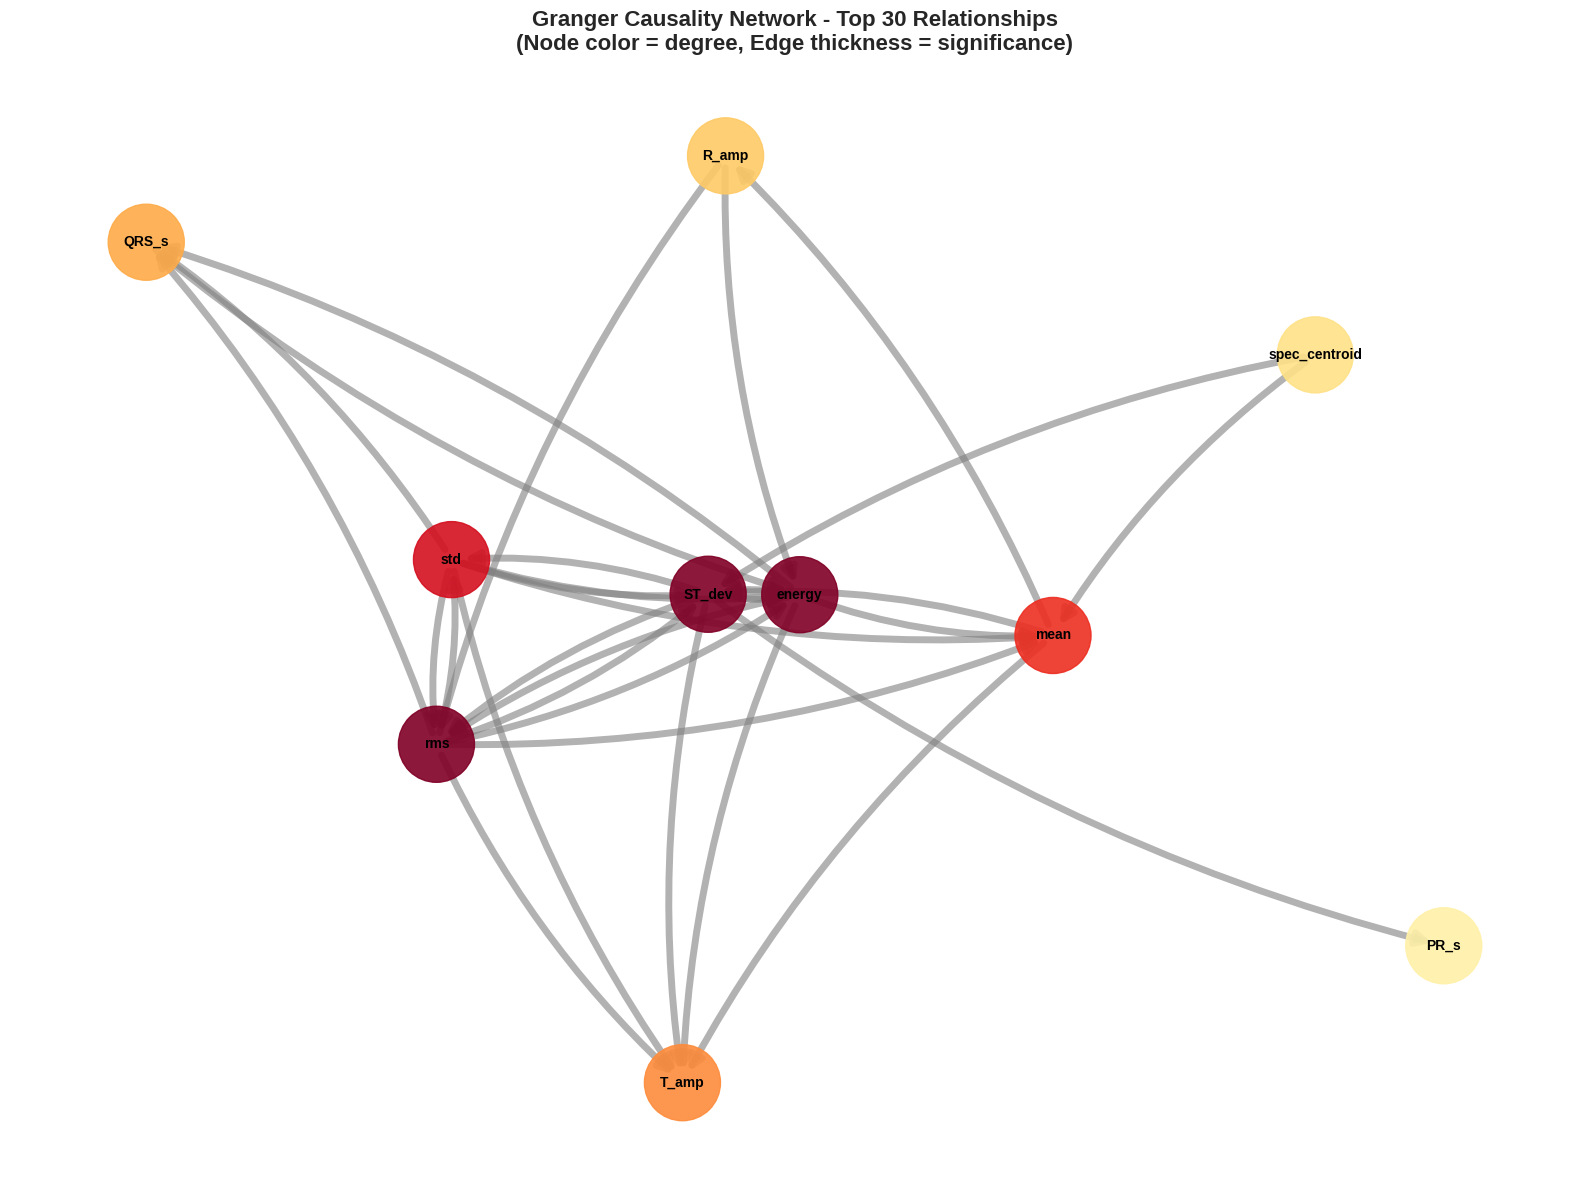

  ✓ Saved: granger_network.png

[2/5] Creating bar chart...


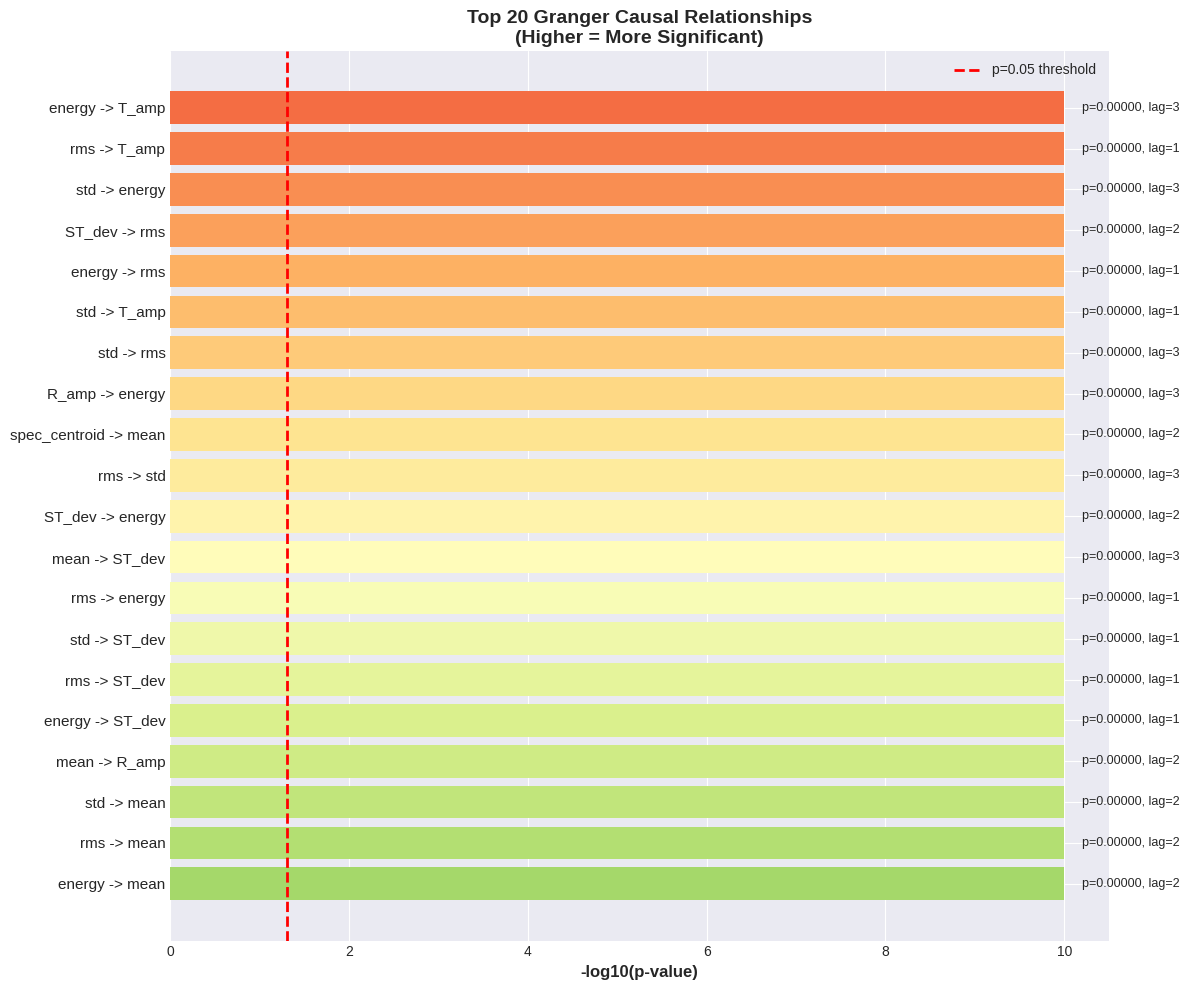

  ✓ Saved: granger_bar_chart.png

[3/5] Creating heatmap...


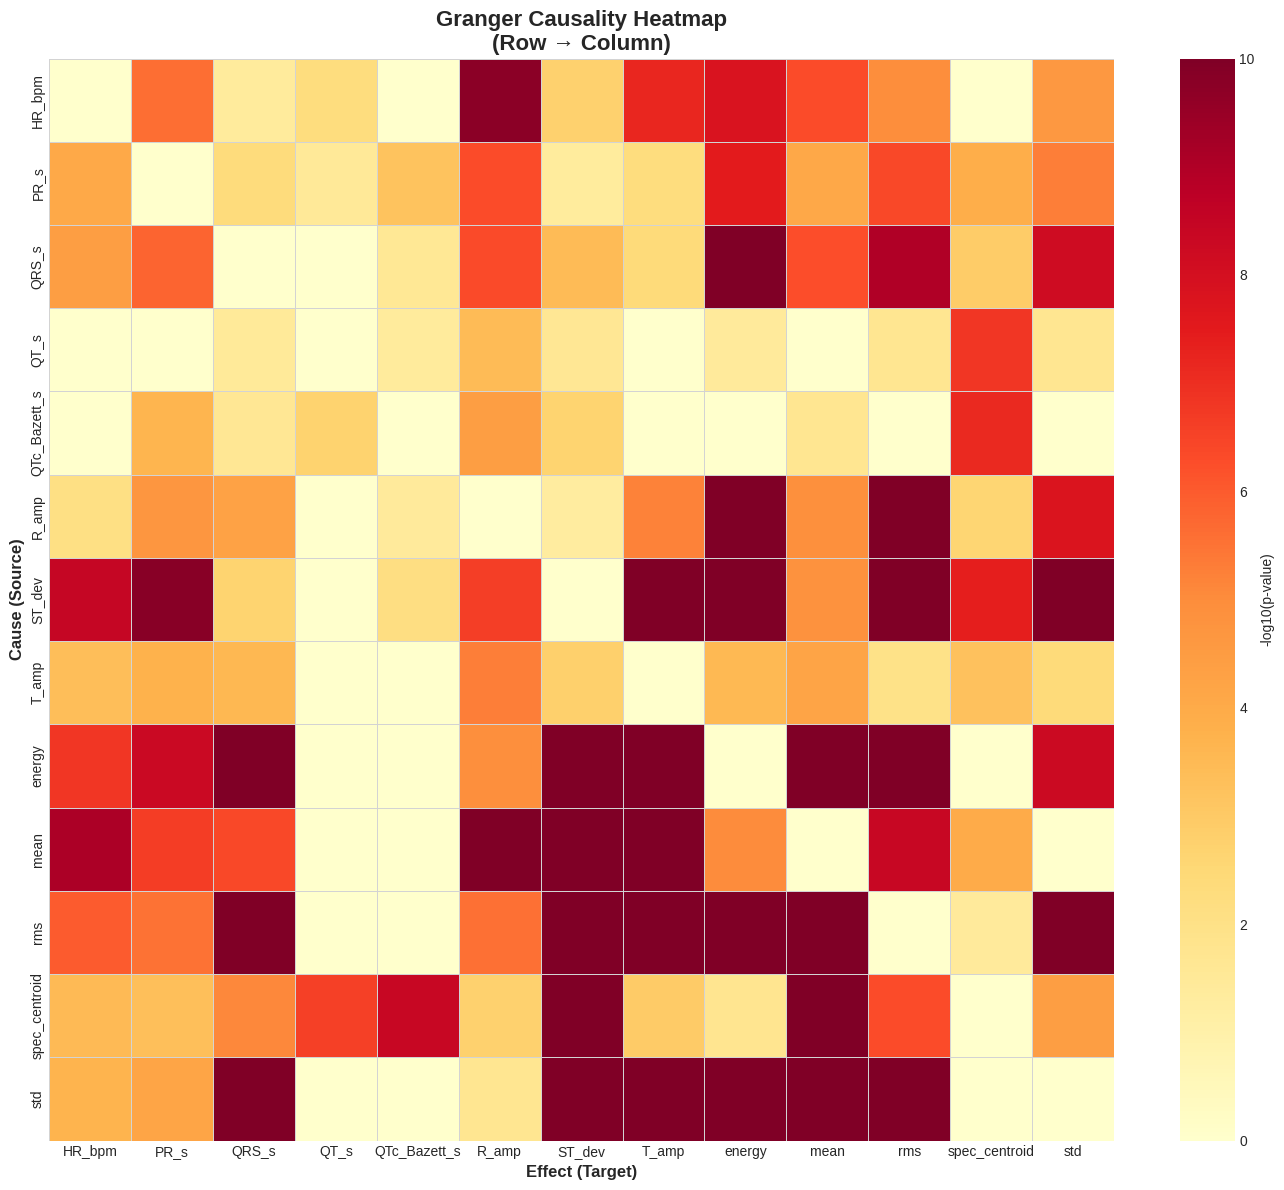

  ✓ Saved: granger_heatmap.png

[4/5] Creating circular diagram...


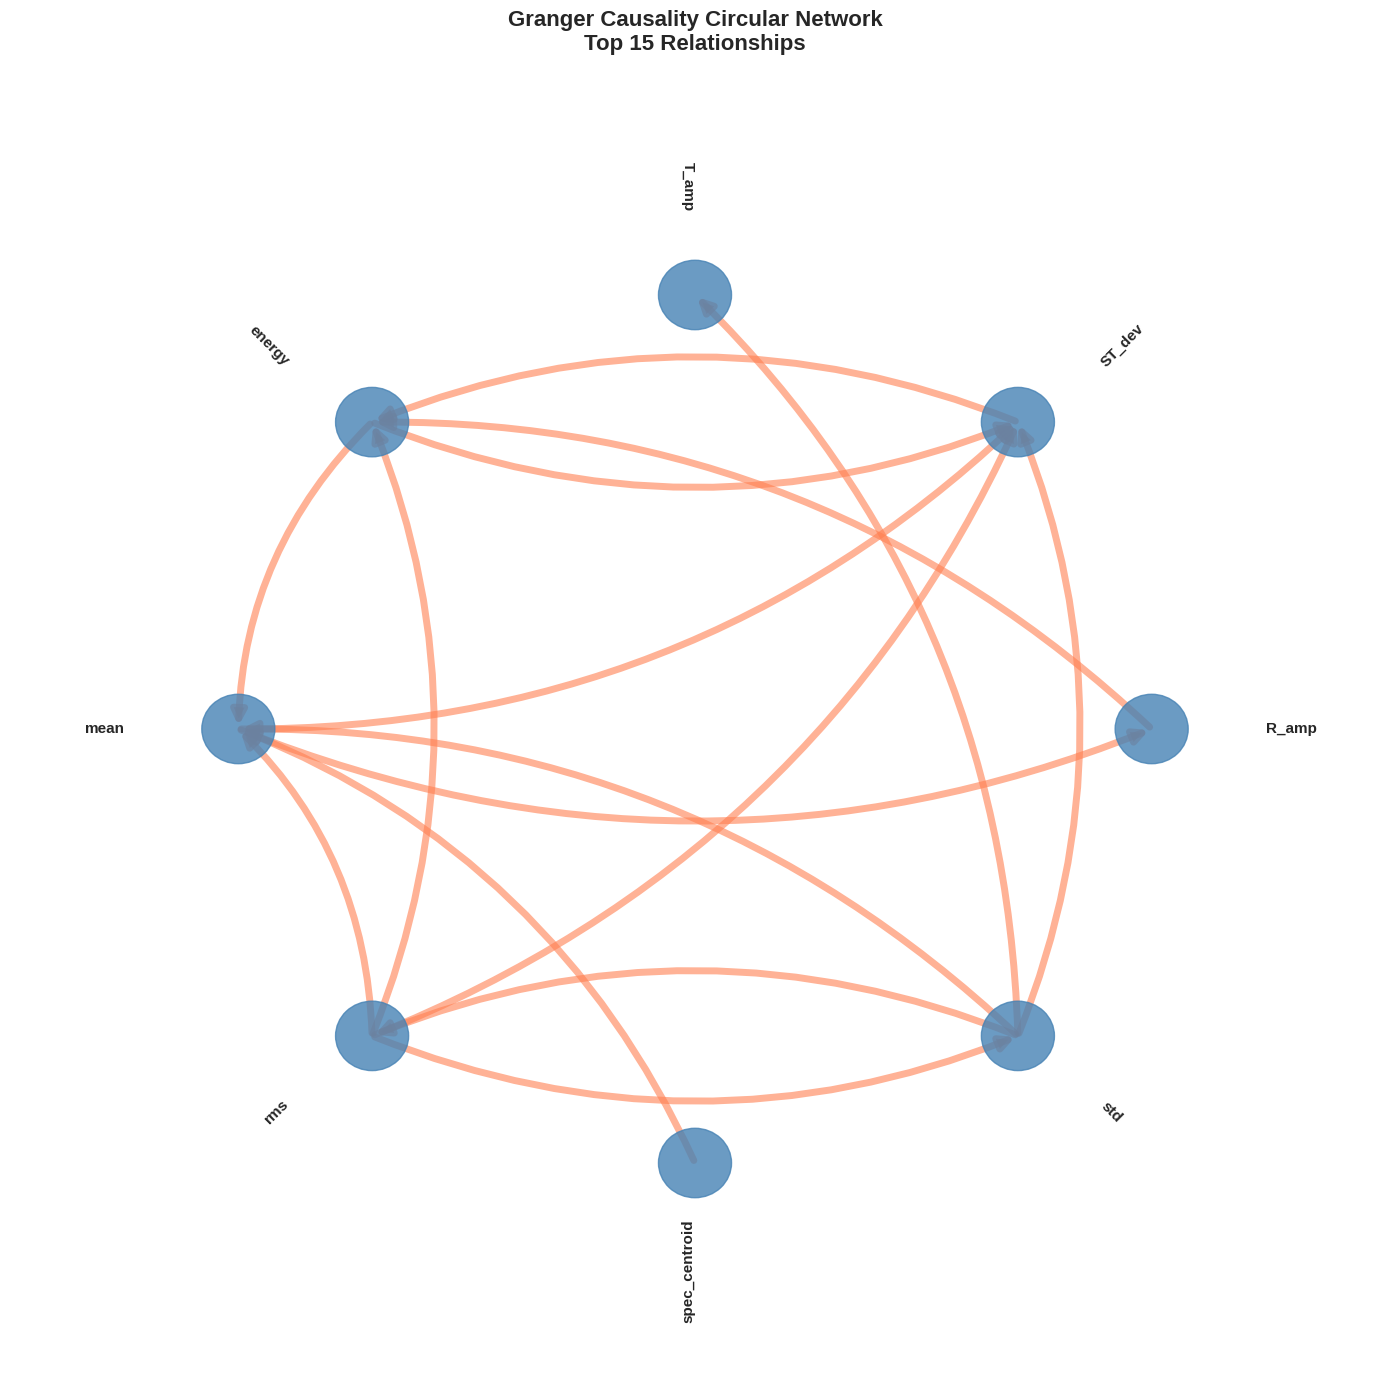

  ✓ Saved: granger_circular.png

[5/5] Creating summary analysis...


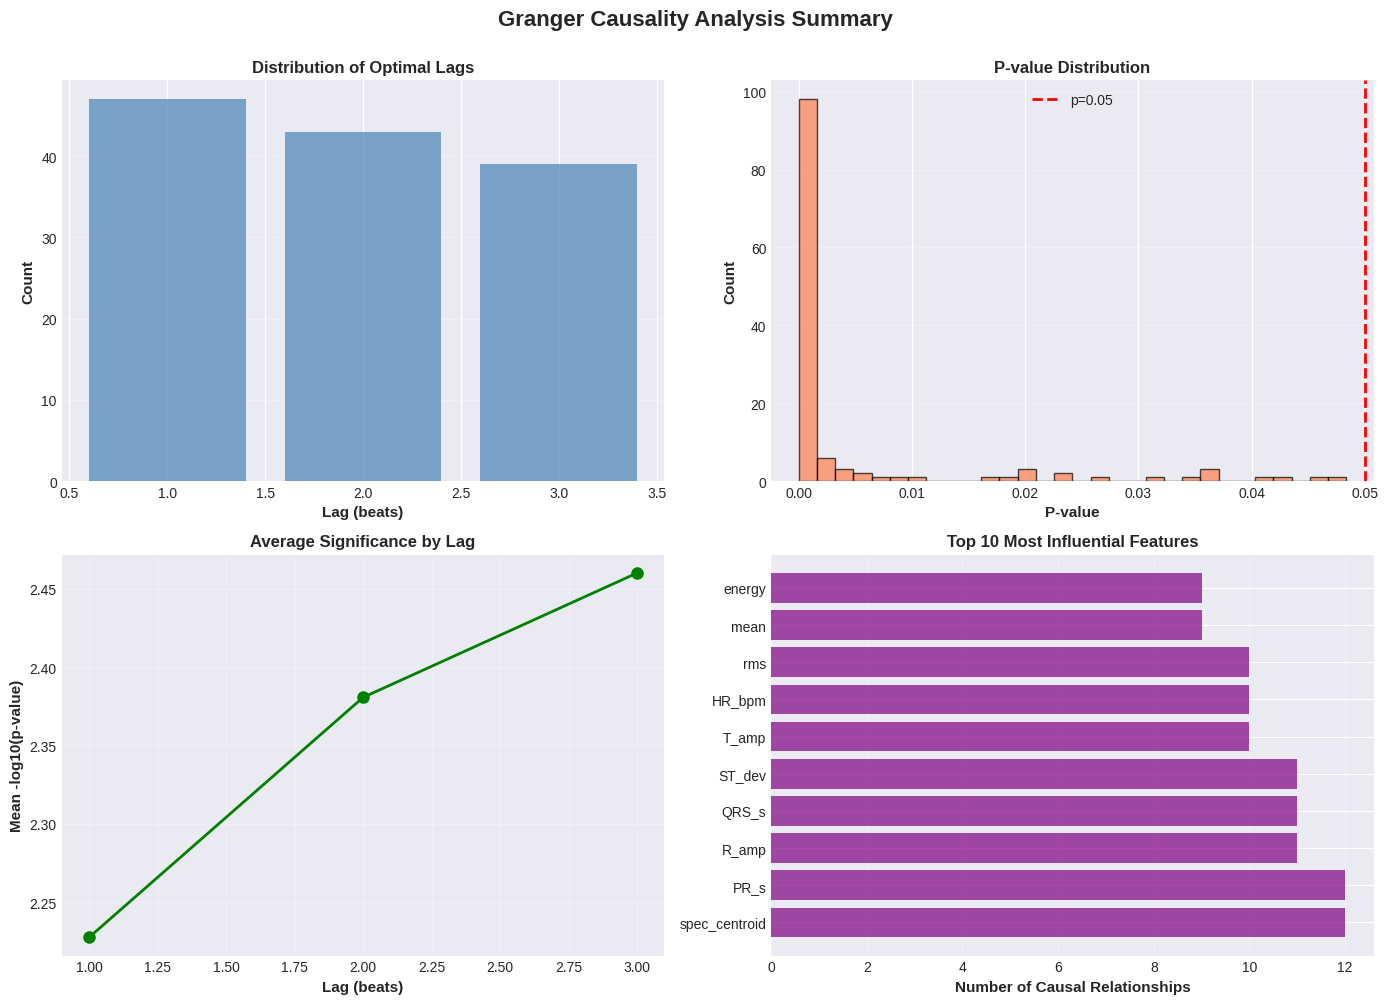

  ✓ Saved: granger_summary.png

✅ ALL VISUALIZATIONS COMPLETE!

Generated files:
  1. granger_network.png - Network graph visualization
  2. granger_bar_chart.png - Top 20 relationships
  3. granger_heatmap.png - Causality matrix heatmap
  4. granger_circular.png - Circular network diagram
  5. granger_summary.png - Statistical summary

📊 Files saved in current Colab directory
   (Right-click files in sidebar to download)


In [ ]:
# Run this in a single Colab cell

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib.patches import FancyArrowPatch, Circle
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*60)
print("GRANGER CAUSALITY VISUALIZATIONS")
print("="*60)

# Load results (try different possible filenames)
result_files = [
    'granger_results_record_105.csv',
    'granger_causality_clinical_record_100.csv',
    'granger_combined_record_105.csv'
]

df_results = None
for filename in result_files:
    try:
        df_results = pd.read_csv(filename, index_col=0)
        print(f"\n✓ Loaded: {filename}")
        print(f"  Total relationships: {len(df_results)}")
        break
    except:
        continue

if df_results is None:
    print("\n❌ No Granger causality results found!")
    print("Please run the Granger causality analysis first.")
else:
    # =========================================
    # VISUALIZATION 1: Network Graph
    # =========================================
    print("\n[1/5] Creating network graph...")

    df_top = df_results.sort_values('p_value').head(30)

    edges = []
    for idx, row in df_top.iterrows():
        cause, effect = idx.split(' -> ')
        weight = -np.log10(row['p_value'] + 1e-10)
        edges.append((cause, effect, weight))

    G = nx.DiGraph()
    for cause, effect, weight in edges:
        G.add_edge(cause, effect, weight=weight)

    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

    node_colors = [G.degree(node) for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                           node_size=3000, cmap='YlOrRd',
                           alpha=0.9, vmin=0, vmax=max(node_colors))

    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=[w*0.5 for w in edge_weights],
                           alpha=0.6, edge_color='gray',
                           arrows=True, arrowsize=20, arrowstyle='-|>',
                           connectionstyle='arc3,rad=0.1')

    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    plt.title('Granger Causality Network - Top 30 Relationships\n(Node color = degree, Edge thickness = significance)',
              fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('granger_network.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print("  ✓ Saved: granger_network.png")

    # =========================================
    # VISUALIZATION 2: Top Relationships Bar Chart
    # =========================================
    print("\n[2/5] Creating bar chart...")

    df_top20 = df_results.sort_values('p_value').head(20)

    fig, ax = plt.subplots(figsize=(12, 10))
    significance = -np.log10(df_top20['p_value'] + 1e-10)

    y_pos = np.arange(len(df_top20))
    bars = ax.barh(y_pos, significance,
                   color=plt.cm.RdYlGn_r(np.linspace(0.3, 0.8, len(df_top20))))

    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_top20.index, fontsize=11)
    ax.set_xlabel('-log10(p-value)', fontsize=12, fontweight='bold')
    ax.set_title('Top 20 Granger Causal Relationships\n(Higher = More Significant)',
                 fontsize=14, fontweight='bold')

    ax.axvline(x=-np.log10(0.05), color='red', linestyle='--',
               linewidth=2, label='p=0.05 threshold')
    ax.legend()

    for i, (idx, row) in enumerate(df_top20.iterrows()):
        ax.text(significance.iloc[i] + 0.2, i,
                f"p={row['p_value']:.5f}, lag={int(row['best_lag'])}",
                va='center', fontsize=9)

    plt.tight_layout()
    plt.savefig('granger_bar_chart.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print("  ✓ Saved: granger_bar_chart.png")

    # =========================================
    # VISUALIZATION 3: Heatmap
    # =========================================
    print("\n[3/5] Creating heatmap...")

    relationships = {}
    for idx, row in df_results.iterrows():
        cause, effect = idx.split(' -> ')
        if cause not in relationships:
            relationships[cause] = {}
        relationships[cause][effect] = -np.log10(row['p_value'] + 1e-10)

    all_features = sorted(set([k for k in relationships.keys()] +
                              [v for vals in relationships.values() for v in vals.keys()]))

    matrix = pd.DataFrame(0.0, index=all_features, columns=all_features)
    for cause, effects in relationships.items():
        for effect, sig in effects.items():
            matrix.loc[cause, effect] = sig

    plt.figure(figsize=(14, 12))
    sns.heatmap(matrix, annot=False, cmap='YlOrRd',
                cbar_kws={'label': '-log10(p-value)'},
                linewidths=0.5, linecolor='lightgray')

    plt.title('Granger Causality Heatmap\n(Row → Column)',
              fontsize=16, fontweight='bold')
    plt.xlabel('Effect (Target)', fontsize=12, fontweight='bold')
    plt.ylabel('Cause (Source)', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig('granger_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print("  ✓ Saved: granger_heatmap.png")

    # =========================================
    # VISUALIZATION 4: Circular Diagram
    # =========================================
    print("\n[4/5] Creating circular diagram...")

    df_top15 = df_results.sort_values('p_value').head(15)

    features = sorted(set([f.split(' -> ')[0] for f in df_top15.index] +
                          [f.split(' -> ')[1] for f in df_top15.index]))

    n_features = len(features)
    angles = np.linspace(0, 2*np.pi, n_features, endpoint=False)
    pos = {feat: (np.cos(a), np.sin(a)) for feat, a in zip(features, angles)}

    fig, ax = plt.subplots(figsize=(14, 14))
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.axis('off')

    for feat, (x, y) in pos.items():
        circle = Circle((x, y), 0.08, color='steelblue', alpha=0.8, zorder=3)
        ax.add_patch(circle)
        angle_deg = np.arctan2(y, x) * 180 / np.pi
        ha = 'left' if -90 < angle_deg < 90 else 'right'
        rotation = angle_deg if -90 < angle_deg < 90 else angle_deg + 180
        ax.text(x*1.25, y*1.25, feat, fontsize=11, fontweight='bold',
                ha=ha, va='center', rotation=rotation)

    for idx, row in df_top15.iterrows():
        cause, effect = idx.split(' -> ')
        x1, y1 = pos[cause]
        x2, y2 = pos[effect]

        width = min(5, -np.log10(row['p_value'] + 1e-10) * 0.5)

        arrow = FancyArrowPatch((x1, y1), (x2, y2),
                               arrowstyle='-|>', mutation_scale=20,
                               lw=width, alpha=0.6, color='coral',
                               connectionstyle='arc3,rad=0.2', zorder=1)
        ax.add_patch(arrow)

    plt.title('Granger Causality Circular Network\nTop 15 Relationships',
              fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('granger_circular.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print("  ✓ Saved: granger_circular.png")

    # =========================================
    # VISUALIZATION 5: Summary Statistics
    # =========================================
    print("\n[5/5] Creating summary analysis...")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Lag distribution
    ax = axes[0, 0]
    lag_counts = df_results['best_lag'].value_counts().sort_index()
    ax.bar(lag_counts.index, lag_counts.values, color='steelblue', alpha=0.7)
    ax.set_xlabel('Lag (beats)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax.set_title('Distribution of Optimal Lags', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    # P-value distribution
    ax = axes[0, 1]
    ax.hist(df_results['p_value'], bins=30, color='coral', alpha=0.7, edgecolor='black')
    ax.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='p=0.05')
    ax.set_xlabel('P-value', fontsize=11, fontweight='bold')
    ax.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax.set_title('P-value Distribution', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # Significance by lag
    ax = axes[1, 0]
    lag_sig = df_results.groupby('best_lag')['p_value'].mean()
    ax.plot(lag_sig.index, -np.log10(lag_sig.values), 'o-', linewidth=2,
            markersize=8, color='green')
    ax.set_xlabel('Lag (beats)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Mean -log10(p-value)', fontsize=11, fontweight='bold')
    ax.set_title('Average Significance by Lag', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)

    # Top causal features
    ax = axes[1, 1]
    cause_counts = {}
    for idx in df_results.index:
        cause = idx.split(' -> ')[0]
        cause_counts[cause] = cause_counts.get(cause, 0) + 1

    top_causes = pd.Series(cause_counts).sort_values(ascending=False).head(10)
    ax.barh(range(len(top_causes)), top_causes.values, color='purple', alpha=0.7)
    ax.set_yticks(range(len(top_causes)))
    ax.set_yticklabels(top_causes.index, fontsize=10)
    ax.set_xlabel('Number of Causal Relationships', fontsize=11, fontweight='bold')
    ax.set_title('Top 10 Most Influential Features', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    plt.suptitle('Granger Causality Analysis Summary', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('granger_summary.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print("  ✓ Saved: granger_summary.png")

    # =========================================
    # Summary
    # =========================================
    print("\n" + "="*60)
    print("✅ ALL VISUALIZATIONS COMPLETE!")
    print("="*60)
    print("\nGenerated files:")
    print("  1. granger_network.png - Network graph visualization")
    print("  2. granger_bar_chart.png - Top 20 relationships")
    print("  3. granger_heatmap.png - Causality matrix heatmap")
    print("  4. granger_circular.png - Circular network diagram")
    print("  5. granger_summary.png - Statistical summary")
    print("\n📊 Files saved in current Colab directory")
    print("   (Right-click files in sidebar to download)")
